## Intelligent Judicial System
### Python Version 2
###### Done By:
###### Anurag Gate
###### Bhakti Mehta
###### Yugal Karamchandani


#### Importing necessary libraries:

In [1]:
import itertools
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#### Reading required datasets and getting rid of invalid columns that provide no information regarding true value:

In [2]:
dataset=pd.DataFrame.from_csv('SCDB_2018_02_caseCentered_Citation.csv',header=0,index_col=None)
variables = ['petitioner','petitionerState','respondent','respondentState','jurisdiction','threeJudgeFdc','caseOrigin','caseOriginState','caseSource','caseSourceState','lcDisagreement','certReason','lcDisposition','lcDispositionDirection','term','naturalCourt','chief','issue','issueArea','decisionDirection','decisionDirectionDissent','authorityDecision1','lawType','voteUnclear','majVotes','minVotes','partyWinning']
dataset=dataset[variables]
issues=pd.DataFrame.from_csv('issues.csv',header=0,index_col=None)
state_codes=pd.DataFrame.from_csv('State_codes.csv',header=0,index_col=None)

C:\Users\Anurag Gate\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
C:\Users\Anurag Gate\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.
C:\Users\Anurag Gate\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """


#### Dealing with Missing Values and Outliers:

In [3]:
dataset['petitionerState'] = dataset['petitionerState'].fillna(0)
dataset['respondentState'] = dataset['respondentState'].fillna(0)
dataset['caseOriginState'] = dataset['caseOriginState'].fillna(0)
dataset['caseSourceState'] = dataset['caseSourceState'].fillna(0)
dataset['lcDisposition'] = dataset['lcDisposition'].fillna(0)
dataset['lawType'] = dataset['lawType'].fillna(0)
dataset=dataset.dropna()
dataset=dataset[dataset ['partyWinning'] != 2]

#### Enumerating the features of datatype string:

In [4]:
chiefs=[]
def assignChief(x):
    if x in chiefs:
        return chiefs.index(x)
    else:
        chiefs.append(x)
        return chiefs.index(x) 
dataset['chief']=dataset['chief'].map(lambda x : assignChief(x))

### Data Exploration:

In [5]:
Is_data_balanced = dataset.partyWinning.value_counts()
Is_data_balanced = Is_data_balanced.reset_index()

C:\Users\Anurag Gate\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Anurag Gate\Anaconda2\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


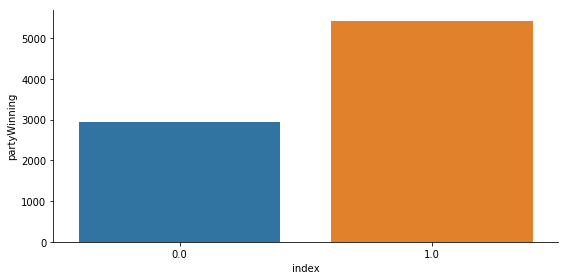

In [6]:
import seaborn as sns
g= sns.factorplot(x="index",y="partyWinning",data=Is_data_balanced,kind="bar",aspect=2, size=4)
new_labels = ['Petitioner_won', 'Petitioner_lost']
plt.show()

#### We can see that the data is imbalanced and can result into wrong accuracy of the model. Thus to avoid imbalanced classification, we will be using Random Upsampling to improve our model.

#### Balancing the dataset:

C:\Users\Anurag Gate\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Anurag Gate\Anaconda2\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


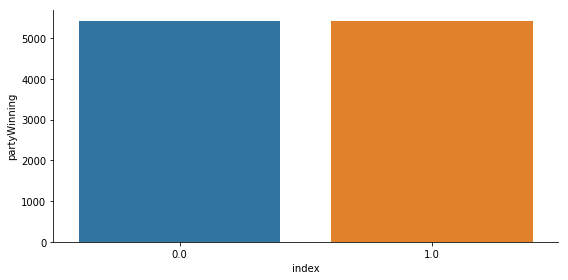

In [7]:
df_majority = dataset[dataset.partyWinning==1]
df_minority = dataset[dataset.partyWinning==0]
from sklearn.utils import resample
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=5426,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
original_data = dataset
dataset=df_upsampled
# Display new class counts
Is_data_balanced = dataset.partyWinning.value_counts()
Is_data_balanced = Is_data_balanced.reset_index()
g= sns.factorplot(x="index",y="partyWinning",data=Is_data_balanced,kind="bar",aspect=2, size=4)
new_labels = ['Petitioner_won', 'Petitioner_lost']
plt.show()

#### Segmenting Years into decades:

In [8]:
original_data['decades']=pd.cut(original_data['term'],[1940,1950,1960,1970,1980,1990,2000,2010,2020],\
                    labels=['1940-1949','1950-1959','1960-1969','1970-1979','1980-1989','1990-1999','2000-2009','2010-present'])

#### Data Exploration - Finding the Winning Rate of the petitioners across various issues:

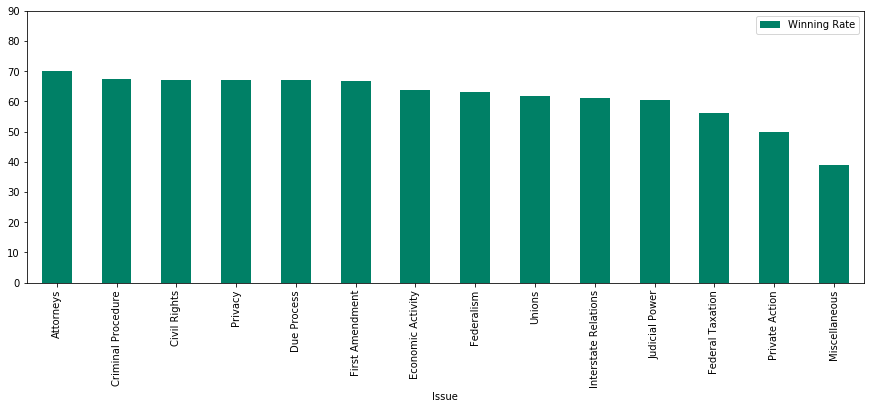

In [9]:
df_winningrate = (original_data[(original_data.partyWinning==1)].groupby(['issueArea','partyWinning'])['issue'].count()/\
original_data.groupby('issueArea')['partyWinning'].count()*100).reset_index().rename(columns={0:'Winning Rate'})
df_winningrate=df_winningrate.sort_values(by=['Winning Rate'],ascending=False)
df_winningVsissue = df_winningrate.merge(issues, how='inner')
df_winningVsissue.plot(x='Issue',y='Winning Rate',kind='bar',colormap='summer',figsize=[15,5], yticks=np.arange(0,100,step=10))
plt.show()

#### Data Exploration - A look into number of petitions and petitions won over the last few decades :

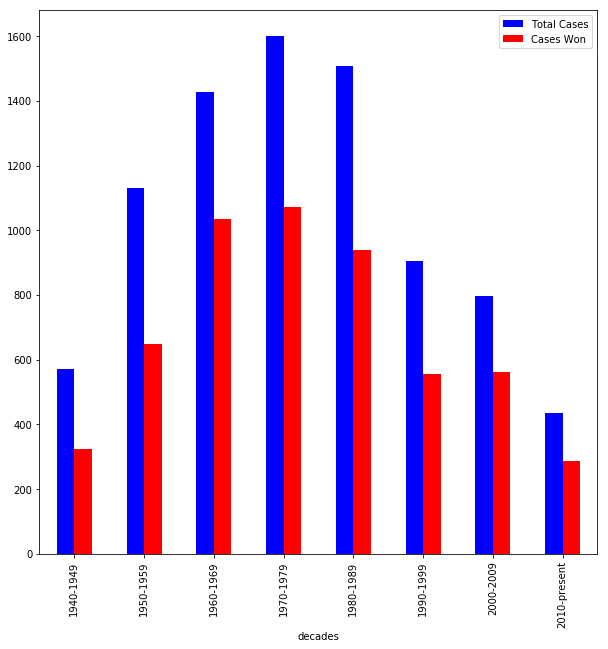

In [10]:
df_totalcases = original_data.groupby('decades')['petitioner'].count()
df_totalcases = df_totalcases.reset_index().rename(columns={'petitioner':'Total Cases'})
df_caseswon = original_data[(original_data.partyWinning==1)].groupby('decades')['petitioner'].count()\
    .reset_index().rename(columns={'petitioner':'Cases Won'})
df_totalcases=df_totalcases.merge(df_caseswon,how='inner')
df_totalcases.plot(x='decades',y=['Total Cases','Cases Won'], kind = 'bar',figsize=(10,10), colormap='bwr')
plt.show()

#### Data Exploration - Top 5 States in the US filing petitions in the United States Supreme Court :

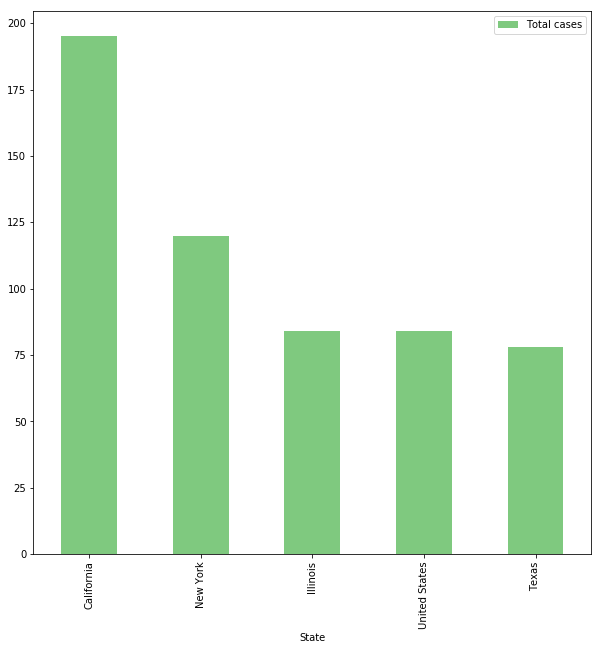

In [11]:
df_states = original_data[original_data.petitionerState !=0]
df_states = df_states.groupby('petitionerState')['petitioner'].count()
df_state_max = df_states.reset_index().rename(columns={'petitioner':'Total cases'}).nlargest(5,'Total cases')
df_states_final = df_state_max.merge(state_codes, how='inner')
df_states_final.plot(x='State',y='Total cases', kind = 'bar',figsize=(10,10), colormap='Accent')
plt.show()

### Defining x, y and spliting the data into Train and Test sets:

In [12]:
x=dataset.drop('partyWinning',axis=1)
y=dataset['partyWinning']
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.2,random_state=42)

C:\Users\Anurag Gate\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Model 1 - Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print 'Accuracy of Logistic Regression Model: ', accuracy_score(y_test,y_pred)

Accuracy of Logistic Regression Model:  0.5992630124366651


#### Parameter Tuning using GridSearchCV:

In [14]:
from sklearn.grid_search import GridSearchCV
def parameter_tuning(model,params):
    param_grid = params
    grid_model = model
    grid = GridSearchCV(grid_model, param_grid, cv=2, n_jobs=-1)
    grid.fit(X_train,y_train)
    return grid.best_estimator_

C:\Users\Anurag Gate\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [15]:
lr_classifierModel = LogisticRegression()
param_grid = {'C': np.linspace(0.1,100,101),'penalty' : ['l1', 'l2']}
lr_best_estimator=parameter_tuning(lr_classifierModel,param_grid)
lr_classifierModel = LogisticRegression(C=lr_best_estimator.C,penalty=lr_best_estimator.penalty)
lr_classifierModel=lr_classifierModel.fit(X_train,y_train)
lr_y_predictions = lr_classifierModel.predict(X_test)
print 'Accuracy of Logistic Regression Model after Parameter tuning : ', accuracy_score(y_test,lr_y_predictions)

Accuracy of Logistic Regression Model after Parameter tuning :  0.6020267157991709


In [16]:
print "The value of C and penalty after parameter tuning is:", lr_best_estimator.C, "and ", lr_best_estimator.penalty, "respectively"

The value of C and penalty after parameter tuning is: 82.018 and  l1 respectively


#### Feature Engineering using Recursive Feature Elimination:

In [17]:
from sklearn.feature_selection import RFE
def Feature_engineering(model):
    rfe = RFE(estimator=model, n_features_to_select=1, step=1)
    fit = rfe.fit(X_train, y_train)
    ranking_array =[]
    ranking_array=fit.ranking_.tolist()
    feature_index=[]
    features=[]
    feature_list = []
    for ranks in ranking_array:
        feature_index.append(ranking_array.index(ranks))
        feature_list = x.columns[ranking_array.index(ranks)]
        features.append({'feature': feature_list,'rank':ranks})
    features=pd.DataFrame(features)
    sorted_features = features.sort_values(by=['rank'])
    return sorted_features # Features with their ranking

In [18]:
sorted_features = Feature_engineering(LogisticRegression(C=lr_best_estimator.C, penalty=lr_best_estimator.penalty))
print 'Top 5 Features:'
sorted_features.head()

Top 5 Features:


,feature,rank
20,decisionDirectionDissent,1
19,decisionDirection,2
10,lcDisagreement,3
23,voteUnclear,4
25,minVotes,5


#### Adding Features according to rank and check the accuracy of the model:

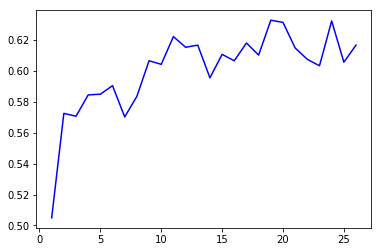

In [19]:
from sklearn.metrics import f1_score
accuracy_data=[]
for i in range(0,len(sorted_features)):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(x[sorted_features['feature'][:i+1]], y, test_size=0.2)
    #classifierModel_new = LogisticRegression()
    classifierModel_new = LogisticRegression(C=lr_best_estimator.C,penalty=lr_best_estimator.penalty)
    classifierModel_new.fit(X_train, y_train)
    y_predicted_lr =  classifierModel_new.predict(X_test)
    accuracy=accuracy_score(y_test,y_predicted_lr)
    f1=f1_score(y_test,y_predicted_lr)
    accuracy_data.append({'features': sorted_features['feature'][:i+1] ,'length': i+1, 'accuracy': accuracy,'f1': f1})
accuracy_df=pd.DataFrame(accuracy_data)
plt.plot(accuracy_df['length'],accuracy_df['accuracy'],color='blue',)
plt.show()

In [20]:
max_accuracy =accuracy_df.sort_values(by=['accuracy'],ascending=False).reset_index().accuracy[0]
print 'The Maximum Accuracy Logistic Regression can achieve is :',max_accuracy

The Maximum Accuracy Logistic Regression can achieve is : 0.6328880700138185


#### Confusion Matrix, Precision  and Recall Score of Logistic Regression:

In [21]:
class_names=['0','1']
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    name = None    
    fmt = 'd'
    thresh = cm.max() / 2
    # i and j tell us the coordinates of boxes
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 0 and j == 0:
            name = "True Negatives"
        elif i == 0 and j == 1:
            name = "False Positives"
        elif i == 1 and j == 1:
            name = "True Positives"
        else:
            name = "False Negatives"
        plt.text(j, i, format(cm[i, j], fmt) + "\n" + name, horizontalalignment="center", 
                 fontsize=23, color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', labelpad=12)
    plt.xlabel('Predicted label', labelpad=12)
    plt.title(title, y=1.02)
    plt.tight_layout()

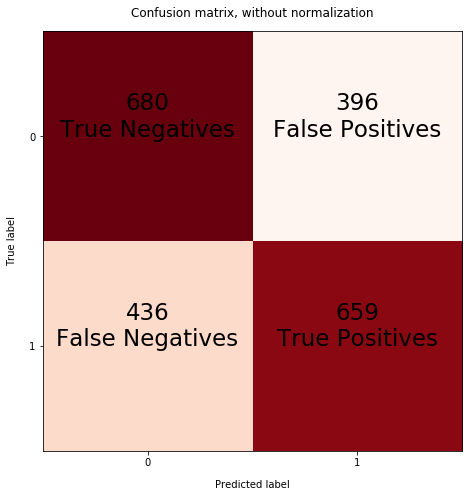

In [22]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted_lr);
np.set_printoptions(precision=2);

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

In [23]:
from sklearn.metrics import recall_score,precision_score
print "The recall_score is : ", recall_score(y_test,y_predicted_lr)
print "The precision_score is : ", precision_score(y_test,y_predicted_lr)

The recall_score is :  0.6018264840182649
The precision_score is :  0.6246445497630332


### Why is Logistic Regression Performing badly?

#### Checking Performance of Logistic Regression on Training data:

In [24]:
#classifierModel_new = LogisticRegression(C=lr_best_estimator.C,penalty=lr_best_estimator.penalty)
classifierModel = LogisticRegression(C=lr_best_estimator.C, penalty=lr_best_estimator.penalty)
my_model = classifierModel.fit(X_train, y_train)
y_pre = my_model.predict(X_train)
print "Train Data Accuracy:", accuracy_score(y_train,y_pre)

Train Data Accuracy: 0.6162884460315632


#### Checking Performance of Logistic Regression on Test data:

In [25]:
y_pre = my_model.predict(X_test)
print "Test Data Accuracy:", accuracy_score(y_test,y_pre)

Test Data Accuracy: 0.6167664670658682


#### Logistic Regression performs badly on Test as well as Train data suggesting that the model is high biased model and cannot pick up the patterns in the dataset.

### Model 2 - Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print 'Accuracy of Random Forest Classifier Model: ', accuracy_score(y_test,y_pred)

Accuracy of Random Forest Classifier Model:  0.973284200829111


C:\Users\Anurag Gate\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


#### Parameter Tuning using GridSearchCV:

In [27]:
rf_classifierModel = RandomForestClassifier(n_estimators=100, n_jobs=-1)
param_grid = {'max_depth': [10, 20, 30, 40]}
rf_best_estimator=parameter_tuning(rf_classifierModel,param_grid)
rf_classifierModel = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=rf_best_estimator.max_depth)
rf_classifierModel=rf_classifierModel.fit(X_train,y_train)
rf_y_predictions = rf_classifierModel.predict(X_test)
print 'Accuracy of Random Forest Model after Parameter tuning : ', accuracy_score(y_test,rf_y_predictions)

Accuracy of Random Forest Model after Parameter tuning :  0.981114693689544


In [28]:
print "The value of maximum depth after parameter tuning is:", rf_best_estimator.max_depth

The value of maximum depth after parameter tuning is: 40


#### We will be using the above parameter in our model to avoid overfitting of data

#### Feature Engineering using Recursive Feature Elimination:

In [29]:
sorted_features = Feature_engineering(RandomForestClassifier(n_estimators=100, n_jobs=-1,max_depth=rf_best_estimator.max_depth))
print 'Top 5 Features:'
sorted_features.head()

Top 5 Features:


,feature,rank
25,minVotes,1
23,voteUnclear,2
24,majVotes,3
1,petitionerState,4
22,lawType,5


#### Adding Features according to rank and check the accuracy of the model:

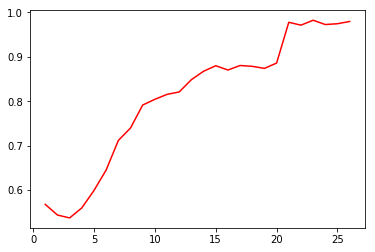

In [30]:
accuracy_data=[]
for i in range(0,len(sorted_features)):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(x[sorted_features['feature'][:i+1]], y, test_size=0.2)
    rf_new = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=rf_best_estimator.max_depth)
    rf_new.fit(X_train, y_train)
    y_predicted_rf =  rf_new.predict(X_test)
    accuracy=accuracy_score(y_test,y_predicted_rf)
    accuracy_data.append({'features': sorted_features['feature'][:i+1] ,'length': i+1, 'accuracy': accuracy})
accuracy_df=pd.DataFrame(accuracy_data)
plt.plot(accuracy_df['length'],accuracy_df['accuracy'],color='red')
plt.show()

In [31]:
max_accuracy =accuracy_df.sort_values(by=['accuracy'],ascending=False).reset_index().accuracy[0]
print 'The Maximum Accuracy Random Forest can achieve is :',max_accuracy

The Maximum Accuracy Random Forest can achieve is : 0.9820359281437125


#### Confusion Matrix, Precision  and Recall Score of Random Forest:

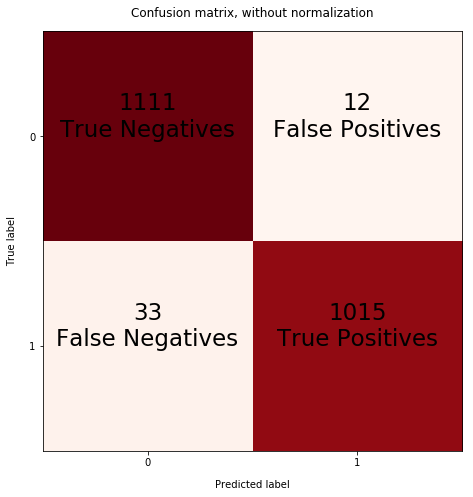

In [32]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted_rf);
np.set_printoptions(precision=2);

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

In [33]:
print "The recall_score is : ", recall_score(y_test,y_predicted_rf)
print "The precision_score is : ", precision_score(y_test,y_predicted_rf)

The recall_score is :  0.9685114503816794
The precision_score is :  0.9883154819863681


#### Checking if Random Forest is Overfitting the dataset?

#### Checking Performance of Random Forest on Training data:

In [34]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=rf_best_estimator.max_depth)
rf_model = rf.fit(X_train,y_train)
y_pre_rf = rf_model.predict(X_train)
accuracy_score(y_train,y_pre_rf)
print "Train Data Accuracy:", accuracy_score(y_train,y_pre_rf)

Train Data Accuracy: 1.0


#### Checking Performance of Random Forest on Test data:

In [35]:
y_pre_rf = rf_model.predict(X_test)
accuracy_score(y_test,y_pre_rf)
print "Test Data Accuracy:", accuracy_score(y_test,y_pre_rf)

Test Data Accuracy: 0.9797328420082911


#### Random Forest performs good on Train as well as Test data and Thus is not overfitting the data.
#### Random Forest gives good accuracy, recall and precision score.
#### We would recommend this algorithm for creating our Machine Learning Model.

### Insights from Data Analysis:

#### Insight 1 : Liberal Vs Conservative Courts

In [36]:
df = original_data[original_data.decisionDirection!=3]
conservative_vs_liberal = df.groupby(['decisionDirection','issueArea'])['petitioner'].count().reset_index().rename(columns={'petitioner' : 'count'})

C:\Users\Anurag Gate\Anaconda2\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Anurag Gate\Anaconda2\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


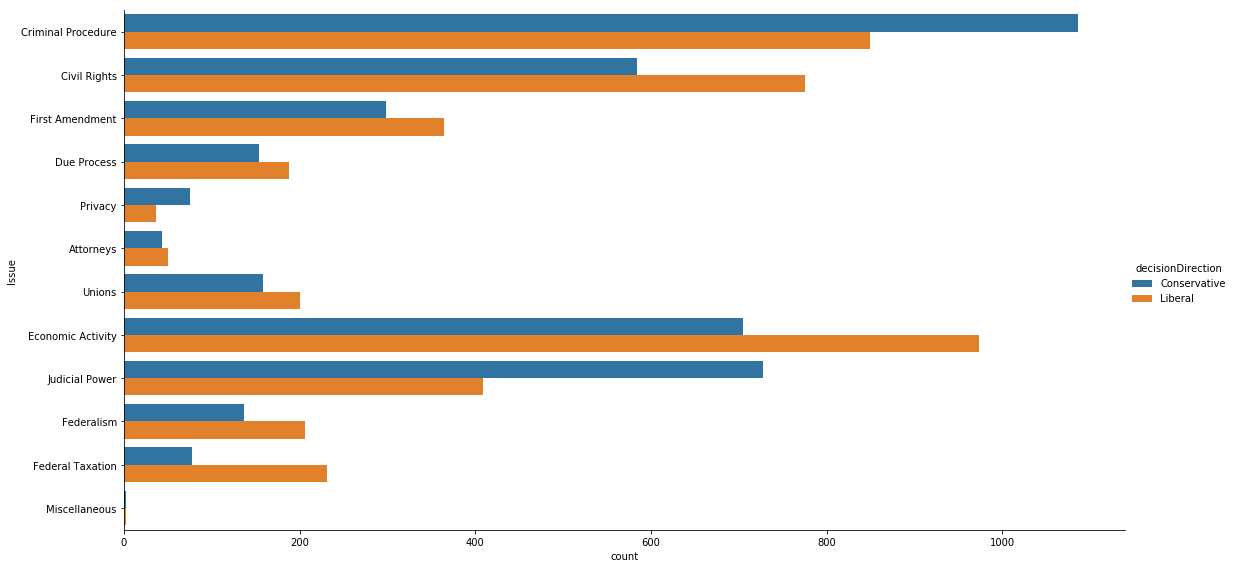

In [37]:
conservative_vs_liberal = conservative_vs_liberal.merge(issues, how='inner')
g=sns.factorplot(x="count",y="Issue",hue="decisionDirection",data=conservative_vs_liberal,kind="bar",aspect=2, size=8)
new_labels = ['Conservative', 'Liberal']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
plt.show()

In recent years, there has been a high percentage of liberal opinions. But voting liberally on a state law for drawing and quartering jaywalkers is different from voting to free a murderer.
Thus as we can see, only in criminal proceedings, Privacy cases and Judicial power cases, the court seems to be mostly conservative.
Reference:https://www.vox.com/mischiefs-of-faction/2016/2/22/11094172/supreme-court-conservative-liberal

#### Hence, the court is usually liberal in various issue areas except in cases based on Criminal activity, Privacy cases and Judicial Power cases

#### Insight 2 : Reversal Rate over the past 5 decades:

In [38]:
affirm_reverse = original_data[(original_data.lcDisposition==2) | (original_data.lcDisposition==3) | (original_data.lcDisposition==4)]
affirm_reverse_filtered= affirm_reverse[((affirm_reverse.lcDisposition==3) | (affirm_reverse.lcDisposition==4)) & (affirm_reverse.lcDispositionDirection!=3)]

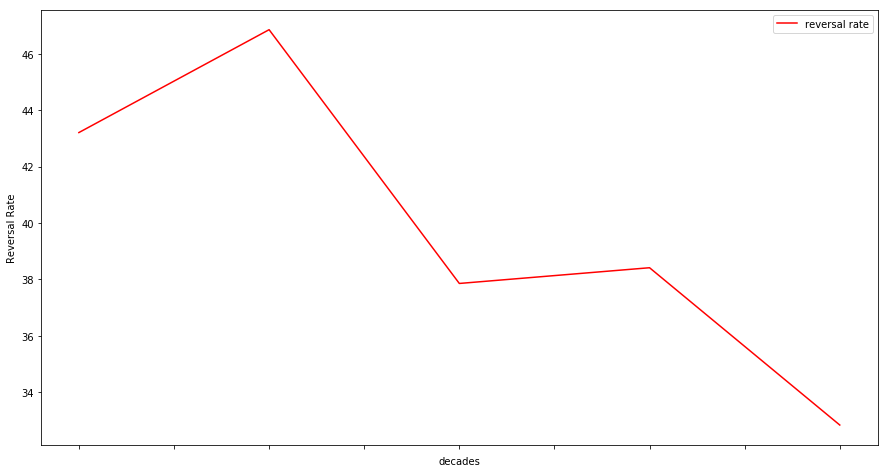

In [39]:
affirm_reverse_count = affirm_reverse_filtered.groupby(['decades',])['petitioner'].count()/\
affirm_reverse[(affirm_reverse.lcDispositionDirection!=3)].groupby('decades')['petitioner'].count()*100
affirm_reverse_count=affirm_reverse_count.reset_index().rename(columns = {'petitioner':'reversal rate'})
reversal_rate = affirm_reverse_count[5:].reset_index()
reversal_rate=affirm_reverse_count.drop([0,1,2])
reversal_rate.plot(x='decades',y='reversal rate',kind='line',figsize=(15,8),colormap='autumn')
plt.ylabel('Reversal Rate')
plt.show()

This decline in Reversal Rates indicate that we are gradually overcoming issues like variability and inconsistenecies in the laws and the courts are now firm about the constitutional provisions and important legal issues to be considered while giving a judgement.
Reference:https://www.americanbar.org/content/dam/aba/migrated/intelprop/magazine/LandslideJan2010_Hofer.authcheckdam.pdf

#### There has been a 10% decrease in the number of cases whose decision has been reversed by the superior court over the past  years.